In [1]:
!pip install tensorflow -q
# !python -v

In [2]:
!pip install SpeechRecognition pydub -q

In [3]:
!pip install toloka-kit -q

!python3.10

In [4]:
!pip install xlrd -q

In [20]:
# Importing all the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os
from pydub import AudioSegment
from pydub.exceptions import CouldntDecodeError
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
import IPython.display as ipd
import os
import glob
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Lambda
import toloka.client
toloka_client = toloka.client.TolokaClient(
  'T13G0USVrAJlXKx4VmjHlA.045e.157M3UiypS9H4MuCrRyOGLpAoHB0LQ9AAE6vZFcLeN8he6cYVsKU2Ne9XJuHJbzi7IJOlHEJxCynEXIC8sHWG_xiL626rBDkVLlJEXzWzsA', 'PRODUCTION')

In [6]:
text_A = pd.read_csv("TextA.tsv", sep='\t')
text_A_add = pd.read_csv("TextA++.tsv", sep='\t')
text_B = pd.read_csv("TextB.tsv", sep='\t')
text_B_add = pd.read_csv("TextB++.tsv", sep='\t')
text_C = pd.read_csv("TextC.tsv", sep='\t')
text_C_add = pd.read_csv("TextC++.tsv", sep='\t')
text_D = pd.read_csv("TextD.tsv", sep='\t')
text_D_add = pd.read_csv("TextD++.tsv", sep='\t')
users = pd.read_excel("users_data.xls")
countries = pd.read_excel("countries.xls")
english_speaking = pd.read_csv("english-speaking-countries-2024.csv")
english_speaking

,country,englishSpeakingCountries_isPrimary,englishSpeakingCountries_deJure,englishSpeakingCountries_deFacto,englishSpeakingCountries_notes
0,India,No,Yes,No,"Two official: Hindi, English. Neither is legal..."
1,United States,Yes,No,Yes,NaN
2,Pakistan,No,Yes,No,Two official: Urdu and English.
3,Nigeria,Yes,Yes,Yes,NaN
4,Bangladesh,No,No,Yes,NaN
...,...,...,...,...,...
82,Anguilla,No,Yes,Yes,English-based creole dialect is widely spoken.
83,Nauru,No,Yes,Yes,Two official: Nauruan and English.
84,Tuvalu,No,Yes,No,NaN
85,Falkland Islands,Yes,Yes,Yes,English is official language.


In [7]:
english_speaking.replace({
                'Yes': True,
                'No': False
            }, inplace = True)
english_speaking['is_english_spoken'] = (english_speaking['englishSpeakingCountries_isPrimary']) | (english_speaking['englishSpeakingCountries_deJure']) | (english_speaking['englishSpeakingCountries_deFacto'])
english_speaking

,country,englishSpeakingCountries_isPrimary,englishSpeakingCountries_deJure,englishSpeakingCountries_deFacto,englishSpeakingCountries_notes,is_english_spoken
0,India,False,True,False,"Two official: Hindi, English. Neither is legal...",True
1,United States,True,False,True,NaN,True
2,Pakistan,False,True,False,Two official: Urdu and English.,True
3,Nigeria,True,True,True,NaN,True
4,Bangladesh,False,False,True,NaN,True
...,...,...,...,...,...,...
82,Anguilla,False,True,True,English-based creole dialect is widely spoken.,True
83,Nauru,False,True,True,Two official: Nauruan and English.,True
84,Tuvalu,False,True,False,NaN,True
85,Falkland Islands,True,True,True,English is official language.,True


In [8]:
#Joining dataset of countries with the dataset of English-speaking countries
countries_joined = pd.merge(countries, english_speaking[['country', 'is_english_spoken']], on='country', how='left')
countries_joined['is_english_spoken'].fillna(False, inplace=True)
countries_joined

,Country code,Region ID,country,is_english_spoken
0,US,84,United States,True
1,AR,93,Argentina,False
2,BR,94,Brazil,False
3,CA,95,Canada,True
4,DE,96,Germany,False
...,...,...,...,...
216,FK,101519,Falkland Islands,True
217,MQ,101521,Martinique,False
218,SS,108137,South Sudan,True
219,SX,109724,Sint Maarten,True


In [9]:
# Concatenating all the texts
texts = pd.concat([text_A, text_A_add, text_B, text_B_add, text_C, text_C_add, text_D, text_D_add])
texts = texts.drop(['GOLDEN:result_3d_question', 'GOLDEN:result_1st_question', 
             'GOLDEN:result_2nd_question', 'GOLDEN:result_4th_question', 
             'HINT:text', 'HINT:default_language', 
             'ASSIGNMENT:status',
             'ASSIGNMENT:started', 'ACCEPT:verdict', 'ACCEPT:comment',
             'ASSIGNMENT:link', 'ASSIGNMENT:task_id'], axis = 1)
texts.head()

,INPUT:audio,INPUT:image,OUTPUT:recording,OUTPUT:result_3d_question,OUTPUT:result_1st_question,OUTPUT:result_2nd_question,OUTPUT:result_4th_question,ASSIGNMENT:assignment_id,ASSIGNMENT:worker_id
0,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.7cc55f72-618c-4ac6-ae75-d9a27bdec249,No,No,No,No,00028edf7c--6613eacdecfe467e31a1b8cb,b2c2c06f6bf8eed800e25881029fbcf7
1,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.c334a2ee-536d-43a3-8f67-972fb9d50d7a,Yes,Yes,No,No,00028edf7c--6613ead849336b29782c831c,6a77f4ba1d04551c0c776dbd7b38e2f5
2,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.7e09aeb4-fa43-4c93-9434-983c2cf8495b,No,No,No,No,00028edf7c--6613eaf349336b29782c8615,6e9fdeeb3d0dfb1afd888aa5c8d347e6
3,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.e0508876-bb3a-4de0-a8ce-c222dd87f1ba,No,No,Yes,Yes,00028edf7c--6613eb144e5be33a301bfdde,f91d95a62d1c07da5f4ddae20e7e6b14
4,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.440419a1-a930-4eb2-b965-fb45c69df94e,No,No,No,No,00028edf7c--6613eb6d4e5be33a301c075d,6de9d807930d55fdddfaf3eecd0c8c13


In [10]:
texts

,INPUT:audio,INPUT:image,OUTPUT:recording,OUTPUT:result_3d_question,OUTPUT:result_1st_question,OUTPUT:result_2nd_question,OUTPUT:result_4th_question,ASSIGNMENT:assignment_id,ASSIGNMENT:worker_id
0,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.7cc55f72-618c-4ac6-ae75-d9a27bdec249,No,No,No,No,00028edf7c--6613eacdecfe467e31a1b8cb,b2c2c06f6bf8eed800e25881029fbcf7
1,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.c334a2ee-536d-43a3-8f67-972fb9d50d7a,Yes,Yes,No,No,00028edf7c--6613ead849336b29782c831c,6a77f4ba1d04551c0c776dbd7b38e2f5
2,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.7e09aeb4-fa43-4c93-9434-983c2cf8495b,No,No,No,No,00028edf7c--6613eaf349336b29782c8615,6e9fdeeb3d0dfb1afd888aa5c8d347e6
3,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.e0508876-bb3a-4de0-a8ce-c222dd87f1ba,No,No,Yes,Yes,00028edf7c--6613eb144e5be33a301bfdde,f91d95a62d1c07da5f4ddae20e7e6b14
4,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.440419a1-a930-4eb2-b965-fb45c69df94e,No,No,No,No,00028edf7c--6613eb6d4e5be33a301c075d,6de9d807930d55fdddfaf3eecd0c8c13
...,...,...,...,...,...,...,...,...,...
375,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.3569cba1-8e98-475a-84fe-971b0dc4c7e9,No,Yes,Yes,Yes,00028ffbe7--664f3cb542ac8f441d6f43be,4c8d438e586e0fec1b8ec7892d810e81
376,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.2b5ec51b-70d7-4031-b831-afe54060cc27,No,No,Yes,Yes,00028ffbe7--664f4f6cdb902752cf421fd8,567dd66e382b195691c4f3af1628e2e7
377,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.a9b263c4-ca44-4fcd-8bb5-dda675a82550,None of the above,Yes,Yes,None of the above,00028ffbe7--664f6669db902752cf442474,84c8f7a7374e16e082dddd051b1ea319
378,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.1b1c26dc-3c87-4e71-ab4f-e3019d6ed609,Yes,Yes,Yes,No,00028ffbe7--664f70bd42ac8f441d74413b,b17812981f87b562db4a81d02227a601


In [11]:
#Dropping the following assignments (manually checked the quality of the recording, it was terrible)
texts = texts.drop(texts[texts['ASSIGNMENT:assignment_id'] == '00028f1722--661d0181aeb55a00a818bff7'].index)
texts = texts.drop(texts[texts['ASSIGNMENT:assignment_id'] == '00028f783b--662d1639cb201c62ab79667b'].index)
texts = texts.drop(texts[texts['ASSIGNMENT:assignment_id'] == '00028f1722--661d027c3306b974e9392d36'].index)
texts = texts.drop(texts[texts['ASSIGNMENT:assignment_id'] == '00028f783b--662d169b567f51718c9d810b'].index)
texts = texts.reset_index(drop=True)

In [12]:
# Ten texts that were given to record
text_dict = {
1 : "When she was a child Jennifer liked sports and she played hockey and basketball for an all-boys team. She also worked as a model. At the age of 14 she knew she wanted to be an actress, so she went to New York City to look for work. She appeared in advertisements for MTV and the fashion company Zara and got work as an actress on TV. Her family moved to Los Angeles so that Jennifer could work on TV and in films.",
2 : "Monday is viewed by many to be the worst day of the week, as it marks the return to work following the weekend, when most full-time employees are given two days off. Most students attend school in the morning and return home in the afternoon (usually from about eight until three or seven until two), and most workers go to work in the morning and return home in the evening (usually from nine to five or eight to four).",
3 : "London is a famous and historic city. It is the capital of England in the United Kingdom. The city is quite popular for international tourism because London is home to one of the oldest-standing monarchies in the western area. Rita and Joanne recently travelled to London. They were very excited for their trip because this was their first journey overseas from the United States.",
4 : "I am living with a very welcoming host family. I have my own private bedroom, but we eat breakfast, lunch, and dinner together. On Sundays, we eat a big home-cooked soup for lunch. In Spain, lunch is usually the biggest meal of the day. It's also very common for people to take a midday nap right after a big meal. I am actually just waking up from my nap right now!",
5 : "My name is Bob. Each day I drive my kids to school. My daughter goes to a school that’s far from our house. It takes 30 minutes to get there. Then I drive my son to his school. It’s close to my job. My daughter is in the sixth grade and my son is in the second. They are both good students. My daughter usually sings her favourite songs while I drive. My son usually sleeps.",
6 : "A red and yellow flag tells you to swim between the flags. They show the supervised area of the beach. This means that lifeguards are watching that area. If there are no red and yellow flags it means there is no supervision. Check with the lifeguards and if you are unsure do not go into the water. Black and white check flag shows where board riding and surfing is not allowed.",
7 : "Lucas goes to school every day of the week. He has many subjects to go to each school day: English, art, science, mathematics, gym, and history. His mother packs a big backpack full of books and lunch for Lucas. His first class is English, and he likes that teacher very much. His English teacher says that he is a good pupil, which Lucas knows means that she thinks he is a good student.",
8 : "You can also take one small laptop bag or handbag that can fit under the seat in front of you. If you have two bags, their total weight cannot be more than the limit. If your bag is too big or too heavy, you will not be allowed to take it onto the plane. Staff will put it in the hold for you and you will have to pay extra. Please make sure mobile phones and other devices are fully-charged so security staff can check them.",
9 : "I live in an apartment. In my city, there is a post office where people mail letters. On Monday, I go to work. I work at the post office. Everyone shops for food at the grocery store. They also eat at the restaurant. The restaurant serves pizza and ice cream. My friends and I often go to the park. We like to play soccer at the park. On Fridays, we go to the cinema to see a movie.",
10 : "Chocolates and flowers are commonly given as gifts during Valentine's Day, as are accompanying greeting cards. Red and pink are generally understood to be the colours of Valentine's Day, and many individuals, instead of celebrating romantically, spend the holiday with their friends or family members."
  }

In [14]:
# Extacting Toloka data using their API and then merging with our 
for index, row in users.iterrows():
    user_data = toloka_client.get_user(row["user_id"])
    temp = countries_joined[countries_joined['Country code'] == user_data.country] # find the country by code
    if (temp.empty):
        print(row)
        print(user_data)
    users.at[index, "country_name"] = temp.at[temp.index[0], 'country']
    users.at[index, "languages"] = user_data.languages
    users.at[index, "english_spoken"] = temp.at[temp.index[0], 'is_english_spoken']
    users.at[index, "country_by_ip"] = user_data.attributes.country_by_ip

/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_7361/449289655.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  users.at[index, "english_spoken"] = temp.at[temp.index[0], 'is_english_spoken']


In [15]:
users

,user_id,submitted_assignments,blocked_income,income,country,age,country_name,languages,english_spoken,country_by_ip
0,000f10e3b3c3cc940df2a551fab4a643,0,0.0,0.00,JP,58,Japan,"[EN, KK, JA, AR, FR, DE]",False,PK
1,00218acc5b3227e3cc0baecf219b6399,0,0.0,0.00,US,29,United States,"[AR, DE, EN, IT, PT, TR]",True,PK
2,007091bf49b06d0bf02e9fb9279f2eb9,4,0.0,0.38,PK,33,Pakistan,"[EN, UR]",True,PK
3,0073bb653e12c1a2a5295ad168fdf175,27,0.0,3.08,KE,25,Kenya,"[SW, EN, TR, IT]",True,KE
4,00898a085f697505517486fe4eed5d08,1,0.0,0.09,US,41,United States,[EN],True,US
...,...,...,...,...,...,...,...,...,...,...
3008,ffb04dad82fef857d8a396b1c13242ba,0,0.0,0.00,US,21,United States,[EN],True,KE
3009,ffb3f2914e1cb5c5dc585556638484fe,0,0.0,0.00,KE,29,Kenya,"[EN, JA, SW, ZH-HANS]",True,KE
3010,ffcd476eb019227ef761ebf63c77caa2,1,0.0,0.09,PH,22,Philippines,"[EN, TL]",True,PH
3011,ffcfac66f9972d1b208393e9a04a4d97,1,0.0,0.09,KE,22,Kenya,"[EN, SW]",True,KE


In [16]:
# Taking users with accepted assignments (income !=0.0)
involved_users = users[users['income'] != 0.0]
involved_users

,user_id,submitted_assignments,blocked_income,income,country,age,country_name,languages,english_spoken,country_by_ip
2,007091bf49b06d0bf02e9fb9279f2eb9,4,0.0,0.38,PK,33,Pakistan,"[EN, UR]",True,PK
3,0073bb653e12c1a2a5295ad168fdf175,27,0.0,3.08,KE,25,Kenya,"[SW, EN, TR, IT]",True,KE
4,00898a085f697505517486fe4eed5d08,1,0.0,0.09,US,41,United States,[EN],True,US
5,0093003258d3ec8b8af7e6e03f489ca5,8,0.0,0.74,SA,34,Saudi Arabia,"[AR, EN]",False,SA
6,00bb9fd1be172bc01d82f19c95f51902,4,0.0,0.38,IN,22,India,"[DE, EN, FR]",True,IN
...,...,...,...,...,...,...,...,...,...,...
3004,ff535f41bc675bce20d5efec3fe63fce,1,0.0,0.09,TW,26,Taiwan,"[ZH, EN, ZH-HANS]",False,TW
3005,ff6712b49f644f2b9defc264655c7f78,1,0.0,0.09,PK,60,Pakistan,"[EN, RU, ES, AR, TR, PT]",True,PK
3006,ff705c5ba2538e54a30b05cff9240bd6,1,0.0,0.09,IN,29,India,[EN],True,IN
3010,ffcd476eb019227ef761ebf63c77caa2,1,0.0,0.09,PH,22,Philippines,"[EN, TL]",True,PH


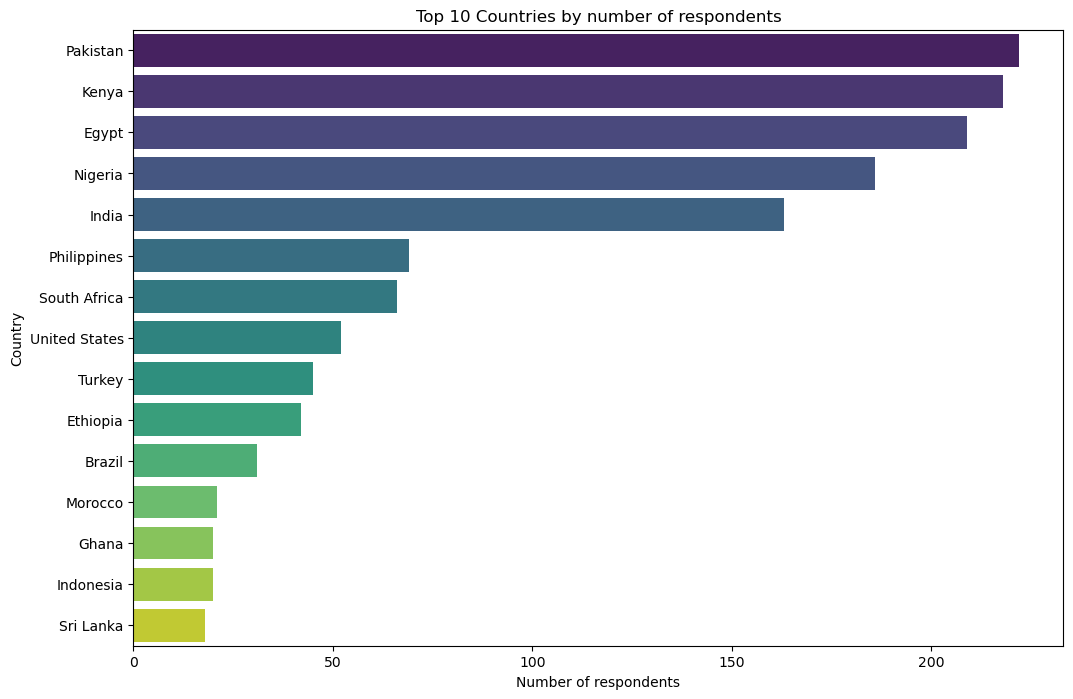

In [17]:
import seaborn as sns

country_counts = involved_users['country_name'].value_counts().reset_index()
country_counts.columns = ['country', 'count']

# Select the top 10 countries
top_10_countries = country_counts.head(15)

plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='country', data=top_10_countries, palette='viridis')
plt.xlabel('Number of respondents')
plt.ylabel('Country')
plt.title('Top 10 Countries by number of respondents')
plt.show()


In [18]:
involved_users.to_csv("users.csv")

In [21]:
# def prepare_voice_file(path: str) -> str:
#     """
#     Converts the input audio file to WAV format if necessary and returns the path to the WAV file.
#     """
#     if os.path.splitext(path)[1] == '.wav':
#         return path
#     elif os.path.splitext(path)[1] in ('.m4a', '.mp4', '.aac','.mp3','.wma', '.ogg', '.amr', '.mpeg', '.opus', '.3gpp'): #('.mp3', '.m4a', '.ogg', '.flac', '.aac', '.wma'):
#         print(os.path.splitext(path)[1][1:])
#         audio_file = AudioSegment.from_file(
#             path, format=os.path.splitext(path)[1][1:])
#         wav_file = os.path.splitext(path)[0] + '.wav'
        
#         audio_file.export(wav_file, format='wav')
#         return wav_file
#     else:
#         raise ValueError(
#             f'Unsupported audio format: {format(os.path.splitext(path)[1])}')

def convert_to_wav (df):
    audio_extensions = ['.m4a', '.mp4', '.aac','.mp3','.wma', '.ogg', '.amr', '.mpeg', '.opus', '.3gpp']
    for filename in df['file_path'] :
        # Get the file extension
        file_ext = os.path.splitext(filename)[1]
        # Check if the file has an audio extension
        if file_ext in audio_extensions:
            # New file path with .wav extension
            new_file = os.path.splitext(filename)[0] + '.wav'
            # Rename the file
            os.rename(filename, new_file)
            # print(f'Renamed "{filename}" to "{new_file}"')

In [22]:
def get_audio_duration(file_path):
    try:
        audio = AudioSegment.from_file(file_path)
        return len(audio) / 1000.0  # duration in seconds
    except (CouldntDecodeError, IndexError):
        print("No duration extraction is available")
        print (file_path)
        return 0

def create_new_path(file_path):
    parts = file_path.rsplit('.', 1)
    return f"{parts[0]}-new.{parts[1]}"

def adjust_audio_duration(file_path, new_path, target_duration):
    audio = AudioSegment.from_file(file_path)
    while (len(audio) / 1000.0) < target_duration:
        audio += AudioSegment.from_file(file_path)  # Repeat the audio
    adjusted_audio = audio[:1000* target_duration]  # Cut any excess
    # print(new_path)
    # print(new_path.rsplit('.',1))
    adjusted_audio.export(new_path, format=new_path.rsplit('.',1)[1])

In [23]:
def get_file_extension(folder_path, file_name_without_extension):
    search_pattern = os.path.join(folder_path, file_name_without_extension + ".*")
    # Use glob to search for the file with the given pattern
    matching_files = glob.glob(search_pattern)
    if matching_files:
        # Extract the extension from the first matching file
        file_path = matching_files[0]
        _, file_extension = os.path.splitext(file_path)
        return file_extension
    else:
        return None 


In [24]:
base_audio_path = '/Users/grigorijcebotarev/Desktop/thesis/Recordings'
audio_extensions = ['.wav', '.m4a', '.mp4', '.aac','.mp3','.wma', '.ogg', '.amr', '.mpeg', '.opus', '.3gpp']
irrelevant_extensions = []
for index, row in texts.iterrows():
    parts = row['INPUT:audio'].split("/")
    filename = parts[-1]
    texts.at[index, 'speechkit_path'] = os.path.join(base_audio_path, "texts_speechkit", filename)
    # Assume no valid file is found initially
    valid_audio_file_path = None
    # Check each extension to find a valid audio file
    for ext in audio_extensions:
        potential_path = os.path.join(base_audio_path, f"assignment_{row['ASSIGNMENT:assignment_id']}"+"/"+row['OUTPUT:recording'] + ext)
        if os.path.isfile(potential_path):
            valid_audio_file_path = potential_path
            break
    
    # If a valid audio file is found, process it and add file path to the dataframe
    if valid_audio_file_path: # and exten not in ['.mp4','.wma', '.amr', '.mpeg', '.opus', '.3gpp', '.aac']:
        texts.at[index, 'file_path'] = valid_audio_file_path
    else:
        texts.at[index, 'file_path'] = "None"
        irrelevant_extensions.append(get_file_extension(os.path.join(base_audio_path, f"assignment_{row['ASSIGNMENT:assignment_id']}"),row['OUTPUT:recording']))

In [26]:
print("The number of irrelevant files is", len(irrelevant_extensions))

The number of irrelevant files is 162


In [27]:
texts[texts['file_path'] == "None"]

,INPUT:audio,INPUT:image,OUTPUT:recording,OUTPUT:result_3d_question,OUTPUT:result_1st_question,OUTPUT:result_2nd_question,OUTPUT:result_4th_question,ASSIGNMENT:assignment_id,ASSIGNMENT:worker_id,speechkit_path,file_path
554,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.7d92bc4d-37ea-43b4-a654-2636351e8a7a,No,Yes,Yes,No,00028edf7c--661b97c3729d87695a3fe872,08d7db98e7b782b9b03bc12c080b1a1b,/Users/grigorijcebotarev/Desktop/thesis/Record...,None
592,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.1aaed99e-10dd-40b5-a2c6-877f99ade2c6,Yes,No,Yes,No,00028f9928--662bd260f81b996bc6149566,037e0d0d1c7e747433779e991122cf23,/Users/grigorijcebotarev/Desktop/thesis/Record...,None
601,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.0c7a7f49-fcfd-41df-9561-8d70acb4b46c,No,Yes,Yes,Yes,00028f9928--662bd2f1567f51718c8771ef,f7b47818093e5746777aa275f6f42da2,/Users/grigorijcebotarev/Desktop/thesis/Record...,None
604,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.927961bc-53d1-425f-8b21-cf8b7f73fb9f,Yes,Yes,No,Yes,00028f9928--662bd308567f51718c877372,80afd87ea35db0eba14aec049ecdcf6a,/Users/grigorijcebotarev/Desktop/thesis/Record...,None
621,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.e1199626-b401-4606-8c0a-bcfa08dc05c0,Yes,Yes,Yes,No,00028f9928--662bd49ccb201c62ab620e16,223325144ec35c74996fc95cc3758393,/Users/grigorijcebotarev/Desktop/thesis/Record...,None
...,...,...,...,...,...,...,...,...,...,...,...
5014,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.b8ffffc5-e66e-487b-9ae8-d7a9570a034e,Yes,Yes,Yes,Yes,00028ffbe7--664a2b33fb6c1e0937c7f9a7,f6ab0ad48da0de7fd9d5fb0bbcca32af,/Users/grigorijcebotarev/Desktop/thesis/Record...,None
5018,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.414327c7-a812-4dd3-925d-d1450086ffa0,No,No,No,Yes,00028ffbe7--664aefbefb6c1e0937ce5de2,54968827e1ffc7a9751a26d7b44675d0,/Users/grigorijcebotarev/Desktop/thesis/Record...,None
5035,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.f0919832-184f-461f-a2a3-12b2c1fb7055,Yes,Yes,Yes,Yes,00028ffbe7--664d3acf46643a735b789d52,b0caa0efa1b0915dfc94a6799b42c2c1,/Users/grigorijcebotarev/Desktop/thesis/Record...,None
5040,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.a2da283a-a0ff-413a-9cc0-5bcede37f8ba,Yes,Yes,Yes,Yes,00028ffbe7--664e5afd30d6fd1d1c633bbf,ab10d879c8970071bc4534a05779f649,/Users/grigorijcebotarev/Desktop/thesis/Record...,None


In [28]:
# Dropping irrelevant files
texts = texts.drop(texts[texts['file_path'] == 'None'].index)

In [29]:
# Convering all audiofiles to .wav format as some of the extensions are not supported 
# by Yandex Speechkit (which will be used to transcribe texts)
convert_to_wav(texts)

In [30]:
#Now let's change the initial file path and check whether we have any recordings with other extensions
base_audio_path = '/Users/grigorijcebotarev/Desktop/thesis/Recordings'
audio_extensions = ['.wav', '.m4a', '.mp4', '.aac','.mp3','.wma', '.ogg', '.amr', '.mpeg', '.opus', '.3gpp']
for index, row in texts.iterrows():
    # Assume no valid file is found initially
    valid_audio_file_path = None
    # Check each extension to find a valid audio file
    for ext in audio_extensions:
        potential_path = os.path.join(base_audio_path, f"assignment_{row['ASSIGNMENT:assignment_id']}"+"/"+row['OUTPUT:recording'] + ext)
        if os.path.isfile(potential_path):
            if (ext != '.wav'):
                print (ext)
            valid_audio_file_path = potential_path
            break
    
    # If a valid audio file is found, process it
    if valid_audio_file_path: # and exten not in ['.mp4','.wma', '.amr', '.mpeg', '.opus', '.3gpp', '.aac']:
        # print(index)
        texts.at[index, 'file_path'] = valid_audio_file_path
    else:
        texts.at[index, 'file_path'] = "None"

In [31]:
# Now we want to compute the duration of all the audios and adjust them to have the same duration
texts['duration'] = texts['file_path'].apply(get_audio_duration)

No duration extraction is available
/Users/grigorijcebotarev/Desktop/thesis/Recordings/assignment_00028f9928--662cd781cb201c62ab74eb17/eu.daeb1783-9344-477c-9d5c-794d393d8564.wav
No duration extraction is available
/Users/grigorijcebotarev/Desktop/thesis/Recordings/assignment_00028fbd33--662fa091375e107843feba8a/eu.ae9f672e-44df-47e5-9849-3c8f1b2f3808.wav
No duration extraction is available
/Users/grigorijcebotarev/Desktop/thesis/Recordings/assignment_00028fbd33--662fa7e6faacc068763b7f41/eu.333a4ca2-c882-4925-94d6-03ef48367bb4.wav
No duration extraction is available
/Users/grigorijcebotarev/Desktop/thesis/Recordings/assignment_00028fbd33--6634d3182fff20106b747674/eu.f9e2b191-84a5-4c66-8250-b1b6452eaabc.wav
No duration extraction is available
/Users/grigorijcebotarev/Desktop/thesis/Recordings/assignment_00028ff54a--663f08d97f8a5f1c23193192/eu.a24d6922-fcd0-4373-91ea-844665ebe597.wav


In [33]:
# Let's have a look at the maximum duration
texts[texts['duration'] == texts['duration'].max()]

,INPUT:audio,INPUT:image,OUTPUT:recording,OUTPUT:result_3d_question,OUTPUT:result_1st_question,OUTPUT:result_2nd_question,OUTPUT:result_4th_question,ASSIGNMENT:assignment_id,ASSIGNMENT:worker_id,speechkit_path,file_path,duration
770,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.4e88abf6-60e3-4f38-8695-aa03765bab13,Yes,Yes,Yes,No,00028f9928--662beadf375e107843c10423,3868b0745d83d0fbf166591cb2b651ee,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,373.178


In [34]:
texts['duration'].nlargest(10)

770     373.178
1376    310.078
3564    180.535
957     127.818
691      99.798
2837     88.840
4021     80.940
4530     80.140
4012     79.520
3601     76.971
Name: duration, dtype: float64

In [35]:
texts['duration'].nsmallest(100)

1291     0.000
2102     0.000
2130     0.000
2389     0.000
3552     0.000
         ...  
4958    10.632
1451    10.656
1169    10.740
666     10.913
1255    11.060
Name: duration, Length: 100, dtype: float64

In [36]:
# By checking manually, we realised that all the recording with duration <= 15.00 are not relevant, 
# i.e. the tolokers didn't record the text properly
texts = texts.drop(texts[texts['duration'] <= 15.00].index)

In [37]:
largest_texts = texts.nlargest(10, 'duration')
largest_texts

,INPUT:audio,INPUT:image,OUTPUT:recording,OUTPUT:result_3d_question,OUTPUT:result_1st_question,OUTPUT:result_2nd_question,OUTPUT:result_4th_question,ASSIGNMENT:assignment_id,ASSIGNMENT:worker_id,speechkit_path,file_path,duration
770,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.4e88abf6-60e3-4f38-8695-aa03765bab13,Yes,Yes,Yes,No,00028f9928--662beadf375e107843c10423,3868b0745d83d0fbf166591cb2b651ee,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,373.178
1376,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.ac21bfae-1682-41e4-8be9-b511c10f67ff,Yes,Yes,Yes,Yes,00028f9928--662cf2dbf81b996bc629be22,9dbaa372523e6805d03c078acdb11dc9,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,310.078
3564,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.7222c282-1ac1-4ccd-9ca6-2943e7bbfc66,Yes,No,No,No,00028ff54a--663f25b918b3266e286f6e14,daa441c0edae2068a5ce3b62e30b7e1e,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,180.535
957,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.7c14b960-fd02-4eb8-9dc4-99b794c912de,No,No,Yes,No,00028f9928--662c319bcb201c62ab6975e5,aee397ac87fb80a6d9ced6fe70f067dc,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,127.818
691,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.82c798a8-af7e-4080-8e94-20ae36a04ede,Yes,Yes,Yes,Yes,00028f9928--662bdcacf6eb632909e8b195,09537fe0c31a3f7cba968a9363230eb2,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,99.798
2837,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.9fd5be1c-1910-47f0-940a-e76f16db516f,None of the above,No,No,None of the above,00028f1722--661be4d8495e7d730e4bcca2,47f5af2a67a2bbd16e116ded0af308d9,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,88.840
4021,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.8b16bc32-4d43-4937-ab7b-81b5d6a4a939,Yes,No,Yes,No,00028f783b--66290c0dc56ff768338322aa,47f5af2a67a2bbd16e116ded0af308d9,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,80.940
4530,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.b82e30d0-b65a-427e-b032-ca841367a02a,None of the above,No,No,None of the above,00028f783b--662d18f6567f51718c9db4c8,47f5af2a67a2bbd16e116ded0af308d9,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,80.140
4012,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.3e7d77c9-0bf0-460a-8686-1c5aa6633cae,Yes,No,Yes,No,00028f783b--66290af650de4e597ce6817f,47f5af2a67a2bbd16e116ded0af308d9,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,79.520
3601,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.20377267-72fa-4839-bce0-254fc62e7a71,Yes,Yes,Yes,No,00028ff54a--663f8c30a6811748becbc7ed,49fecb301ed417a6e011f6fe9ba0964b,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,76.971


In [38]:
# Similarly, we checked manually the recordings with duration >= 90. 
# It usually means that tolokers submitted a song or another irrelevant long file
texts = texts.drop(texts[texts['duration'] > 90.00].index)

In [39]:
# Create new path to save the adjusted recording there
texts['new_path'] = texts['file_path'].apply(create_new_path)
texts['new_speechkit_path'] = texts['speechkit_path'].apply(create_new_path)

In [40]:
#Now we are ready to adjust our recording to have the same duration across all audiofiles
max_duration = texts['duration'].max()
for index, row in texts.iterrows():
    if row['duration'] < max_duration:
        # Adjusting both speechkit and voice recordings
        adjust_audio_duration(row['file_path'], row['new_path'], max_duration)
        adjust_audio_duration(row['speechkit_path'], row['new_speechkit_path'], max_duration)

In [41]:
#Let's extract the number of the recorded text to use it in feature extraction (to compute Levenshtein distance).
t = []
for index, row in texts.iterrows():
    parts = row['INPUT:image'].split("/")
    filename = parts[-1]
    number = int(filename.split(".")[0])
    t.append(number)
texts['assigned_text'] = t

In [42]:
texts.head(3)

,INPUT:audio,INPUT:image,OUTPUT:recording,OUTPUT:result_3d_question,OUTPUT:result_1st_question,OUTPUT:result_2nd_question,OUTPUT:result_4th_question,ASSIGNMENT:assignment_id,ASSIGNMENT:worker_id,speechkit_path,file_path,duration,new_path,new_speechkit_path,assigned_text
0,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.7cc55f72-618c-4ac6-ae75-d9a27bdec249,No,No,No,No,00028edf7c--6613eacdecfe467e31a1b8cb,b2c2c06f6bf8eed800e25881029fbcf7,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,66.72,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,1
1,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.c334a2ee-536d-43a3-8f67-972fb9d50d7a,Yes,Yes,No,No,00028edf7c--6613ead849336b29782c831c,6a77f4ba1d04551c0c776dbd7b38e2f5,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,36.88,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,3
2,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.7e09aeb4-fa43-4c93-9434-983c2cf8495b,No,No,No,No,00028edf7c--6613eaf349336b29782c8615,6e9fdeeb3d0dfb1afd888aa5c8d347e6,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,24.54,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,3


In [ ]:
from speechkit import configure_credentials, creds
# Let's transcribe the recordings in order to compute Levenhstein distance in the next notebook
# This cell does not work on M1/M2, so I ran this part in Yandex Cloud 
configure_credentials(
    yandex_credentials=creds.YandexCredentials(
        api_key='AQVN3noCx_0ioYDEUjRI3svPlHtpDF9KmvOnbeLP'
    )
)
from speechkit import model_repository
from speechkit.stt import AudioProcessingType

model = model_repository.recognition_model()

model.model = 'general:rc'
model.language = 'en-US'
model.audio_processing_type = AudioProcessingType.Full

for index, row in texts.iterrows():
	try:
		result = model.transcribe_file(row['file_path'])
		print(index)
		for c, res in enumerate(result):
			texts.at[index, 'transcribed_text'] = res.normalized_text
	except BaseException as e:
		print("Unable to transcribe")
texts.to_csv("prepared_texts.csv")

### Now let's move to our feature extraction notebook, where we will extract audio features and prepare our data for model building